Sources:
- https://onlinelibrary.wiley.com/doi/book/10.1002/9781118106907 (HG106 .A44)
- https://web.p.ebscohost.com/ehost/detail/detail?vid=0&sid=4e5f9e98-927b-488b-b494-01b7f1def4e6%40redis&bdata=JkF1dGhUeXBlPWlwJnNpdGU9ZWhvc3QtbGl2ZSZzY29wZT1zaXRl#AN=52240&db=nlebk
  (HG4925.5 .G74)

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import pypfopt
from pypfopt import CLA, plotting, expected_returns, risk_models

import yfinance as yf
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*1)),  # max 2 requests per 1 second
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache"),
)
session.headers['User-agent'] = 'my-program/1.0'

Note: we can do daily returns, monthly returns, annual returns, etc., for different periods.
Also, the below code uses closing prices, which is somewhat arbitrary.

In [134]:
tickers = ['intc', 'gme', 'cost', 'vst'] 
start_date = '2017-01-01' # inclusive
end_date = '2017-01-31' # exclusive

# set number of assets (= number of qubits)
num_assets = len(tickers)
close_df = pd.DataFrame()

for i, ticker in enumerate(tickers):
    yf_ticker = yf.Ticker(ticker, session=session)
    close_df[ticker] = yf_ticker.history(start=start_date, end=end_date)["Close"]

In [135]:
returns_df = pd.DataFrame()
for ticker in tickers:
    # returns_df[ticker] = (close_df[ticker] - close_df[ticker].shift(1)) / close_df[ticker].shift(1)
    # returns_df = returns_df.dropna()
    returns_df = close_df.pct_change().dropna()

# expected return for each asset
expected_returns_ = np.array(returns_df.mean())

# sample variance
variances = np.array(returns_df.cov())

# sample correlation
correlations = np.array(returns_df.corr())

expected_returns_, variances, correlations

(array([ 0.00126749, -0.00237989,  0.00123876,  0.00345721]),
 array([[ 7.61329916e-05, -6.14004873e-06, -1.07838695e-05,
         -2.81057743e-05],
        [-6.14004873e-06,  5.83712089e-04, -2.01601658e-05,
         -1.21883399e-05],
        [-1.07838695e-05, -2.01601658e-05,  5.74038709e-05,
          2.99656241e-05],
        [-2.81057743e-05, -1.21883399e-05,  2.99656241e-05,
          3.25443218e-04]]),
 array([[ 1.        , -0.02912635, -0.1631239 , -0.17855479],
        [-0.02912635,  1.        , -0.1101347 , -0.02796453],
        [-0.1631239 , -0.1101347 ,  1.        ,  0.21923764],
        [-0.17855479, -0.02796453,  0.21923764,  1.        ]]))

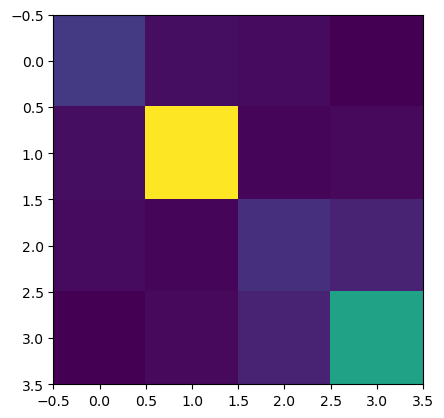

array([[ 7.61329916e-05, -6.14004873e-06, -1.07838695e-05,
        -2.81057743e-05],
       [-6.14004873e-06,  5.83712089e-04, -2.01601658e-05,
        -1.21883399e-05],
       [-1.07838695e-05, -2.01601658e-05,  5.74038709e-05,
         2.99656241e-05],
       [-2.81057743e-05, -1.21883399e-05,  2.99656241e-05,
         3.25443218e-04]])

In [136]:
# for the qiskit VQE demo:
mu = expected_returns_
sigma = variances

# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

sigma

Given weights $w_1 + \dots + w_n = 100 \%$, where $w_i = \frac{V_i}{V_p}$ is the $i$th asset's value as a fraction of the the portfolio's value:
- the portfolio's expected rate of return is the weighted average $k_p = \sum^n_{i=1} w_i k_{ei}$
- the portfolio's risk is the standard deviation $\sqrt{\sum^n_{i=1} \sum^n_{j=1} w_i w_j \text{Cov}_{ij}}$. (As you might imagine, the variation can also be a measure of risk.)

In [137]:
example_portfolio = [
    (0, 0.5),
    (1, 0.25),
    (2, 0),
    (3, 0.25)
]

weights = np.array(example_portfolio)[:,1]
example_return = weights.dot(expected_returns_)
example_return

0.0009030719736536953

In [138]:
example_risk = (
    weights.dot(variances.dot(weights))
) ** 0.5
example_risk

0.008109898661227175

In [147]:
# generate an efficient frontier graph using random portfolios

num_portfolios = 5000
returns = []
risks = []
weights = []

for _ in range(0, num_portfolios):
    portfolio_order = np.random.permutation(np.arange(num_assets))
    remaining_weight = 1
    _weights = np.zeros(num_assets)
    for i in portfolio_order[:-1]:
        _weight = np.random.random() * remaining_weight
        remaining_weight -= _weight
        _weights[i] = _weight
    _weights[portfolio_order[-1]] = remaining_weight
    returns.append(_weights.dot(expected_returns_))
    risks.append(_weights.dot(variances.dot(_weights)) ** 0.5)
    weights.append(_weights)

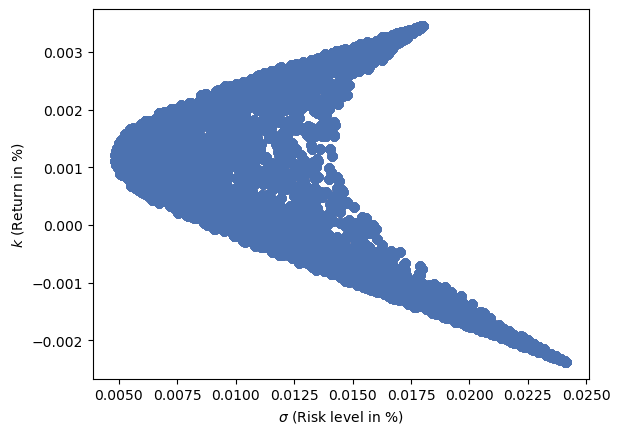

In [148]:
plt.plot(risks * 100, returns * 100, 'o')
plt.xlabel("$\sigma$ (Risk level in %)")
plt.ylabel("$k$ (Return in %)")
plt.show()

In [155]:
max_sharpe = (0,)
for i in range(0, len(risks)):
    _return, _risk, _weights = returns[i], risks[i], weights[i]
    _risk = _risk
    _sharpe = _return / _risk
    if _sharpe > max_sharpe[0]:
        max_sharpe = (_sharpe, _risk, _annual_return, _weights)
print(max_sharpe[3])
# print("Expected return:", max_sharpe[2])
# print("Expected annual return:", (1 + max_sharpe[2]) ** (252) - 1)
# print("Risk:", max_sharpe[2])
# print("Annual volatility:", (1 + max_sharpe[1]) ** (252) - 1)
print("Sharpe Ratio:", max_sharpe[0])

[4.17786943e-01 1.41322655e-04 3.95885465e-01 1.86186269e-01]
Sharpe Ratio: 0.3034668078469112


In [156]:
# xref with pypfopt
# adapted from tutorial code from pypfopt/example/examples.ipynb on their gh rep
frequency=len(returns_df)
mu = expected_returns.mean_historical_return(close_df, frequency=frequency)
S = risk_models.sample_cov(close_df, frequency=frequency)

mu, S

(intc    0.022404
 gme    -0.046906
 cost    0.022037
 vst     0.061198
 dtype: float64,
           intc       gme      cost       vst
 intc  0.001370 -0.000111 -0.000194 -0.000506
 gme  -0.000111  0.010507 -0.000363 -0.000219
 cost -0.000194 -0.000363  0.001033  0.000539
 vst  -0.000506 -0.000219  0.000539  0.005858)

PyPfOpt calculates the Sharpe ratio as $$S_R = \frac{\mu - \text{Risk-free rate}}{\sigma} = \frac{\mu - 0.02}{\sigma}$$

However, do also note that PyPfOpt calcluates <b>log returns</b>. This means the each return is $r_{i+1} = \log \left(1 + \frac{p_{i+1} - p_{i}}{p_{i}} \right)$ and the mean historical return is $\left[ \Pi_{i=2}^n \left( 1 + r_{i+1} \right) \right]^{n} - 1$. The covariance matrix is made with log returns, <u>then multiplied by $n$.</u>

OrderedDict([('intc', 0.42924109720424936), ('gme', 6.020856566745425e-18), ('cost', 0.374101683963517), ('vst', 0.19665721883223355)])
Expected annual return: 3.0%
Annual volatility: 2.4%
Sharpe Ratio: 0.42


<AxesSubplot:xlabel='Volatility', ylabel='Return'>

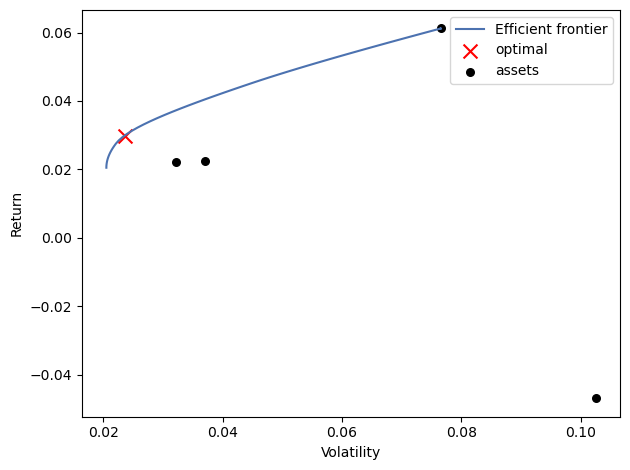

In [157]:
cla = CLA(mu, S)
print(cla.max_sharpe())
cla.portfolio_performance(verbose=True)
plotting.plot_efficient_frontier(cla)  # to plot

In [145]:
# TO-DO
# The weights of the "monte carlo" method seem to match the weight of the pypfopt.
# Need to figure out how to connect daily returns/risk with annualized returns/volatility of pypfopt.